<a href="https://colab.research.google.com/github/ghubnerr/andrej-karpathy-course/blob/main/makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-12-16 17:33:47--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2023-12-16 17:33:47 (54.0 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
block_size = 3 # context length
X, Y = [], []

for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)


In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
C = torch.randn((27,2)) # embeddings
C[5]

In [ ]:
# F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.0160,  0.6061])

In [ ]:
# C[torch.tensor([5,6,7])]  pytorch syntax
C[X].shape
X[13, 2]
C[X][13, 2]

tensor([-1.0526, -1.0336])

In [ ]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [ ]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)


```torch.cat```
Concatenates the given sequence of seq tensors in the given dimension. All tensors must either have the same shape (except in the concatenating dimension) or be empty.

```torch.unbind```Removes a tensor dimension. Returns a tuple of all slices along a given dimension, already without it.



In [ ]:
# emb @ W1 + b1 will not work cz emb.shape == ([32,3,2])

# Does not generalize to block_size cause we're indexing directly
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

# Not so effective or intuitive
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [ ]:
a = torch.arange(18)
a.view(3, 3, 2) # so long as product(*args) == 18, it works

# no memory is being changed, moved, copied or created in .view()
a.storage() # strides and offsets are manipulated

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [ ]:
# the flattening stacks and concatenates dims 1 and 2
emb.view(32, 6)

# you can see these are the same through
emb.view(32, 6) == torch.cat(torch.unbind(emb,1), 1)

emb.view(32, 6) @ W1 + b1

tensor([[ 0.8172, -0.9170, -3.0292,  ..., -2.0148,  0.6171, -6.1917],
        [ 4.1056, -0.6986, -2.4897,  ..., -1.5592,  0.1344, -1.9598],
        [ 1.3138,  0.3854, -2.3925,  ..., -3.0336, -0.4042, -2.8751],
        ...,
        [ 1.7698,  1.3194, -2.1230,  ...,  1.5888,  0.2454, -0.4666],
        [-3.3043,  2.1614,  0.1970,  ...,  0.1246,  0.2790,  1.6464],
        [-2.5756,  1.9557,  0.7114,  ..., -0.5896, -1.6980, -2.9399]])

In [ ]:
# mind the broadcasting at + b1
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # at -1, pytorch infers the dim

In [ ]:
h.shape

torch.Size([32, 100])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([32, 27])

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdims=True)

In [ ]:
prob.shape

torch.Size([32, 27])

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.2562)

In [ ]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [ ]:
# ------------ better --------------- #

In [ ]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

`cross_entropy` is more efficient due to the fused kernel, the offset balancing and the backward pass swiftness

In [ ]:
for p in parameters:
  p.requires_grad = True

`torch.linspace` creates n numbers within a range in a linear fashio

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri, lossi = [], []

for i in range(10): # overfitting a single batch of the data in 3481 params
  # forward pass
  emb = C[X]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Y) # pytorch equivalent, more efficient

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad # learning rate configuration

  # track stats
  lri.append(lr)
  lossi.append(loss.item())

print(loss.item())


# you can't completely overfit cause of the ... thingy

18.33494758605957


In [ ]:
# mini-batch pass -> quality of gradient is lower, but makes more steps

lri, lossi = [], []

for i in range(1000): # overfitting a single batch of the data in 3481 params
  # mini-batch construct
  ix = torch.randint(0, X.shape[0], (32,))


  # forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Y[ix]) # pytorch equivalent, more efficient

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad # learning rate configuration

  # track stats
  lri.append(lr)
  lossi.append(loss.item())

print(loss.item())

# you can't completely overfit cause of the ... thingy

7.2179274559021


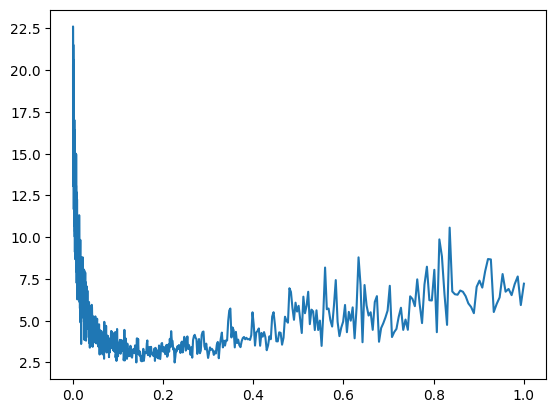

In [ ]:
plt.plot(lri, lossi)

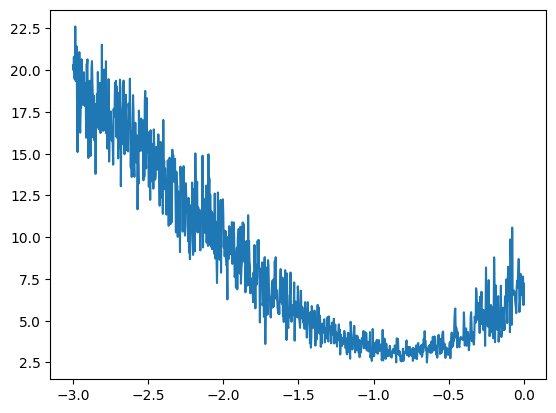

In [ ]:
plt.plot(lre, lossi)

In [ ]:
# mini-batch pass -> quality of gradient is lower, but makes more steps

lri, lossi = [], []

for i in range(10000): # overfitting a single batch of the data in 3481 params
  # mini-batch construct
  ix = torch.randint(0, X.shape[0], (32,))


  # forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Y[ix]) # pytorch equivalent, more efficient

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 10e-3 # found decent LR at 10e-1 then proceed with LR decay
  for p in parameters:
    p.data += -lr * p.grad # learning rate configuration

  # track stats
  lri.append(lr)
  lossi.append(loss.item())

print(loss.item())

# you can't completely overfit cause of the ... thingy

2.5332798957824707


In [ ]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

2.317650318145752

In [ ]:
# training split, dev/val split, test split
# 80%, 10%, 10%
# 80% -> paramaters
# 10% -> hyperparameters
# 10% -> evaluate performance

In [ ]:
def build_dataset(words):
  block_size = 3 # context length
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
# mini-batch pass -> quality of gradient is lower, but makes more steps

lri, lossi = [], []

for i in range(10000): # overfitting a single batch of the data in 3481 params
  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))


  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Ytr[ix]) # pytorch equivalent, more efficient

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 10e-2 # found decent LR at 10e-1 then proceed with LR decay
  for p in parameters:
    p.data += -lr * p.grad # learning rate configuration

  # track stats
  lri.append(lr)
  lossi.append(loss.item())

print(loss.item())

# you can't completely overfit cause of the ... thingy

2.1419315338134766


At this point we identify we need to scale up the size of the network to be able to underfit less in terms of the data we have (since performance on Xtr and Xdev are almost the same)

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.4834113121032715

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.479689121246338

# Increasing the size of the neural network

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
# mini-batch pass -> quality of gradient is lower, but makes more steps

lri, lossi, stepi = [], [], []

for i in range(50000): # overfitting a single batch of the data in 3481 params
  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))


  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Ytr[ix]) # pytorch equivalent, more efficient

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 10e-2 # found decent LR at 10e-1 then proceed with LR decay
  for p in parameters:
    p.data += -lr * p.grad # learning rate configuration

  # track stats
  # lri.append(lr)
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())


2.4917590618133545


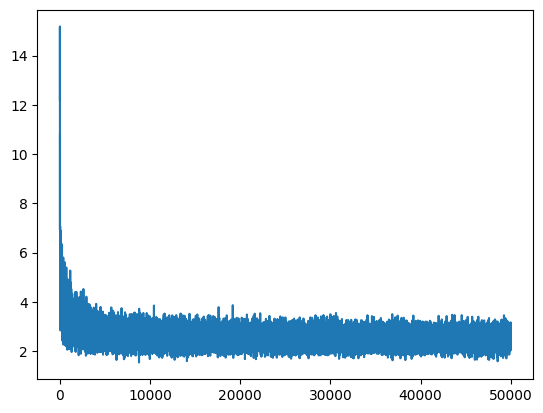

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.4166388511657715

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.4537835121154785

Here, we see that the constraint to the performance may be the embedding vectors

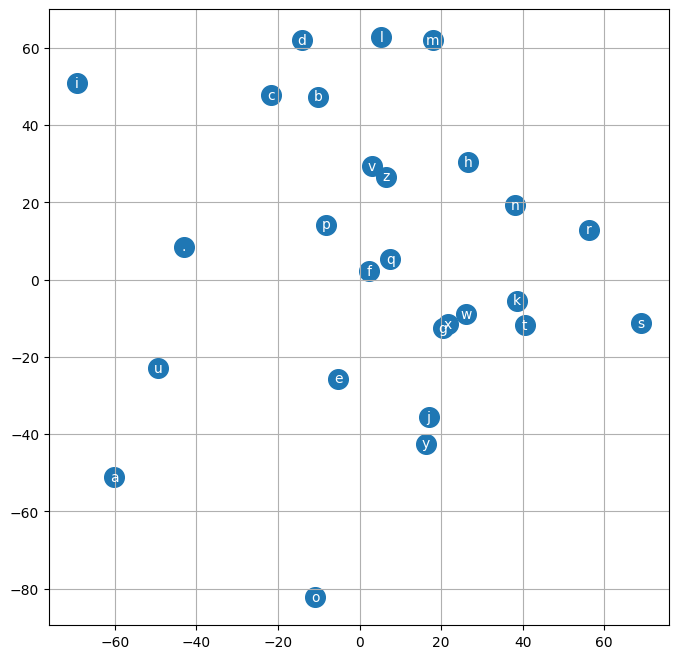

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

# Increasing Embedding Size

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lri, lossi, stepi = [], [], []

In [ ]:
# mini-batch pass -> quality of gradient is lower, but makes more steps

for i in range(50000): # overfitting a single batch of the data in 3481 params
  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))


  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Ytr[ix]) # pytorch equivalent, more efficient

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 10e-2 # found decent LR at 10e-1 then proceed with LR decay
  for p in parameters:
    p.data += -lr * p.grad # learning rate configuration

  # track stats
  # lri.append(lr)
  stepi.append(i)
  lossi.append(loss.log10().item()) # looks nicer cause it squashes it

print(loss.item())


2.516914129257202


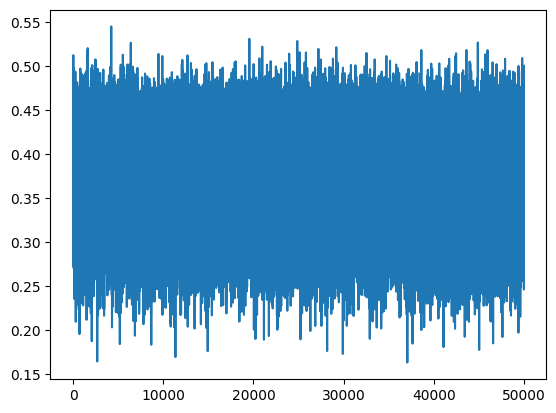

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.3417348861694336

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.3768768310546875

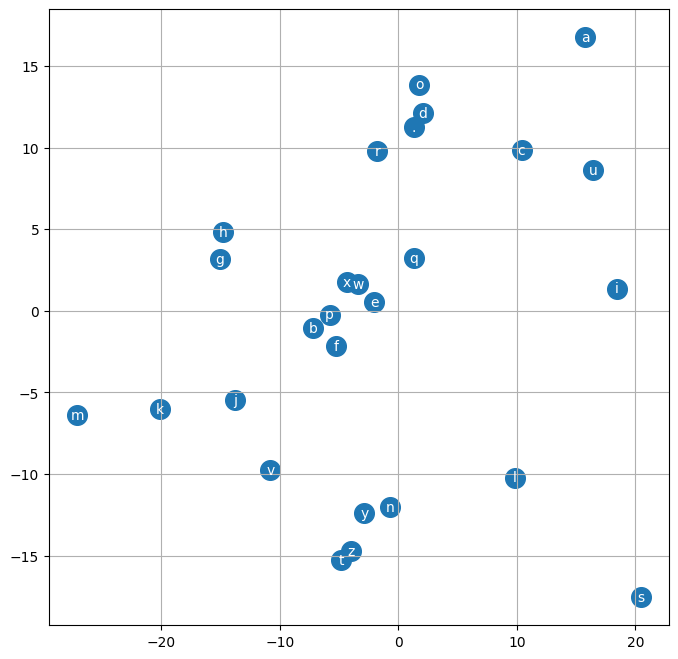

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [ ]:
for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

maran.
chi.
nen.
riuh.
cardo.
joveis.
romigo.
daelyinkeln.
ade.
jae.
anderthied.
mer.
adimir.
non.
chadelia.
yicahaizeii.
jer.
ivelrantii.
javeinnie.
mikke.
